# 03 - Model Comparison

## Objective
Compare the ElasticNet baseline with alternative models (SVM, Random Forest) to validate our approach.

## Models Compared
1. **ElasticNet Logistic Regression** (PRIMARY - Interpretable)
2. **SVM with RBF Kernel** (Non-linear comparison)
3. **Random Forest** (Ensemble, less interpretable)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import json
import random
import warnings
warnings.filterwarnings('ignore')

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.model_selection import (
    StratifiedKFold, GridSearchCV, cross_val_predict, cross_validate,
)
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
PROJECT_ROOT = Path.cwd().parent
DATA_DIR = PROJECT_ROOT / "data"
REPORTS_DIR = PROJECT_ROOT / "reports"
FIGURES_DIR = REPORTS_DIR / "figures"
TABLES_DIR = REPORTS_DIR / "tables"

for d in [FIGURES_DIR, TABLES_DIR]:
    d.mkdir(parents=True, exist_ok=True)

EXPRESSION_FILE = "HiSeqV2.csv"
PAM50_LABELS_FILE = "brca_pam50.csv.csv"

RANDOM_SEED = 42
CV_FOLDS = 5
VARIANCE_THRESHOLD = 0.01
LOG_TRANSFORM_THRESHOLD = 100
DEFAULT_FEATURE_K = 200
PRIMARY_METRIC = "f1_macro"

SAMPLE_ID_CANDIDATES = ["sample", "sample_id", "patient_id", "barcode", "Sample", "SAMPLE_ID"]
PAM50_LABEL_CANDIDATES = ["PAM50", "pam50", "Subtype", "subtype", "label", "Label"]
EXCLUDED_LABELS = ["Unknown", "unknown", "NA", "N/A", "", None]

PAM50_COLORS = {
    "LumA": "#3498db", "LumB": "#2ecc71", "Her2": "#e74c3c",
    "Basal": "#9b59b6", "Normal": "#f39c12",
}

ELASTICNET_PARAMS = {"C": list(np.logspace(-3, 2, 10)), "l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9]}
ELASTICNET_DEFAULTS = {"solver": "saga", "penalty": "elasticnet", "class_weight": "balanced",
                        "max_iter": 5000, "random_state": RANDOM_SEED, "n_jobs": -1}
SVM_PARAMS = {"C": list(np.logspace(-2, 2, 5)), "gamma": ["scale", "auto"] + list(np.logspace(-4, 0, 5))}
SVM_DEFAULTS = {"kernel": "rbf", "class_weight": "balanced", "random_state": RANDOM_SEED, "probability": True}
RF_DEFAULTS = {"class_weight": "balanced", "random_state": RANDOM_SEED, "n_jobs": -1}

np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

plt.rcParams.update({
    "figure.dpi": 100, "savefig.dpi": 150, "font.size": 10,
    "axes.labelsize": 11, "axes.titlesize": 12, "legend.fontsize": 9,
    "figure.figsize": (8, 6), "axes.spines.top": False, "axes.spines.right": False,
})

In [3]:
class Log2Transformer(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=100.0, force=False):
        self.threshold = threshold
        self.force = force
        self.applied_ = False
    def fit(self, X, y=None):
        self.applied_ = self.force or (np.nanmax(np.asarray(X)) > self.threshold)
        return self
    def transform(self, X):
        X = np.asarray(X, dtype=np.float64)
        if self.applied_:
            X = np.log2(np.clip(X, 0, None) + 1)
        return X
    def get_feature_names_out(self, input_features=None):
        return input_features


def normalize_sample_id(sid):
    sid = str(sid).strip()
    return sid[:15] if sid.startswith("TCGA-") and len(sid) >= 15 else sid


def load_data():
    df = pd.read_csv(DATA_DIR / EXPRESSION_FILE, index_col=0)
    if any(str(c).startswith("TCGA-") for c in df.columns[:10]):
        df = df.T
    df.index = [normalize_sample_id(s) for s in df.index]
    df = df.apply(pd.to_numeric, errors="coerce")
    print(f"Expression: {df.shape}")

    ldf = pd.read_csv(DATA_DIR / PAM50_LABELS_FILE)
    sc = next((c for c in SAMPLE_ID_CANDIDATES if c in ldf.columns), ldf.columns[0])
    lc = next((c for c in PAM50_LABEL_CANDIDATES if c in ldf.columns), ldf.columns[1])
    labels = ldf[[sc, lc]].copy()
    labels.columns = ["sample_id", "PAM50"]
    labels["sample_id"] = labels["sample_id"].apply(normalize_sample_id)
    labels = labels.drop_duplicates(subset="sample_id", keep="first")
    labels = labels[~labels["PAM50"].isin(EXCLUDED_LABELS)]

    overlap = set(df.index) & set(labels["sample_id"])
    labels = labels[labels["sample_id"].isin(overlap)]
    X = df.loc[labels["sample_id"].values]
    y = pd.Series(labels["PAM50"].values, name="PAM50")
    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)
    print(f"Labeled: {len(y)}, Distribution: {y.value_counts().to_dict()}")
    return X, y

In [4]:
def _safe_cv_folds(y, cv_folds):
    mc = pd.Series(y).value_counts().min()
    if mc < cv_folds:
        safe = max(2, mc)
        print(f"  CV folds capped: {cv_folds} -> {safe}")
        return safe
    return cv_folds


def _create_pipeline(classifier, n_features):
    return Pipeline([
        ("log_transform", Log2Transformer(threshold=LOG_TRANSFORM_THRESHOLD)),
        ("variance_filter", VarianceThreshold(threshold=VARIANCE_THRESHOLD)),
        ("scaler", StandardScaler()),
        ("feature_selector", SelectKBest(score_func=f_classif, k=n_features)),
        ("classifier", classifier),
    ])


def tune_and_evaluate(X, y, model_name):
    n_samples = len(y)
    max_k = n_samples - 1
    base_k = [k for k in [100, 200, 500] if k <= max_k] or [min(100, max_k)]

    if model_name == "ElasticNet":
        pipe = _create_pipeline(LogisticRegression(C=1.0, l1_ratio=0.5, **ELASTICNET_DEFAULTS), base_k[0])
        grid = {"feature_selector__k": base_k,
                "classifier__C": ELASTICNET_PARAMS["C"],
                "classifier__l1_ratio": ELASTICNET_PARAMS["l1_ratio"]}
    elif model_name == "SVM":
        pipe = _create_pipeline(SVC(**SVM_DEFAULTS), base_k[0])
        grid = {"feature_selector__k": base_k,
                "classifier__C": SVM_PARAMS["C"],
                "classifier__gamma": SVM_PARAMS["gamma"]}
    elif model_name == "RandomForest":
        pipe = _create_pipeline(RandomForestClassifier(n_estimators=100, max_depth=10,
                                                       min_samples_leaf=2, **RF_DEFAULTS), base_k[0])
        grid = {"feature_selector__k": base_k,
                "classifier__n_estimators": [100, 200],
                "classifier__max_depth": [10, 20, None],
                "classifier__min_samples_leaf": [1, 2]}
    else:
        raise ValueError(f"Unknown model: {model_name}")

    cv_folds = _safe_cv_folds(y, CV_FOLDS)
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=RANDOM_SEED)

    print(f"\n--- Tuning {model_name} ---")
    gs = GridSearchCV(pipe, grid, cv=cv, scoring=PRIMARY_METRIC,
                      n_jobs=-1, verbose=1, refit=True, return_train_score=True)
    gs.fit(X, y)
    print(f"  Best {PRIMARY_METRIC}: {gs.best_score_:.4f}")
    print(f"  Best params: {gs.best_params_}")

    best = gs.best_estimator_
    y_pred = cross_val_predict(best, X, y, cv=cv, n_jobs=-1)
    scoring = {"f1_macro": "f1_macro", "f1_weighted": "f1_weighted", "accuracy": "accuracy"}
    cv_res = cross_validate(best, X, y, cv=cv, scoring=scoring, n_jobs=-1, return_train_score=True)
    scores = {}
    for m in scoring:
        scores[m] = {"test_mean": cv_res[f"test_{m}"].mean(), "test_std": cv_res[f"test_{m}"].std(),
                     "train_mean": cv_res[f"train_{m}"].mean(), "train_std": cv_res[f"train_{m}"].std()}

    return best, y_pred, scores, gs.best_params_

## 1. Load Data

In [5]:
X_all, y_all = load_data()

mask = y_all != "Normal"
X = X_all[mask].reset_index(drop=True)
y = y_all[mask].reset_index(drop=True)
CLASSES_USED = sorted(y.unique().tolist())

print(f"Using {len(y)} samples, {len(CLASSES_USED)} classes: {CLASSES_USED}")

Expression: (1218, 20530)
Labeled: 70, Distribution: {'LumB': 25, 'LumA': 18, 'Basal': 15, 'Her2': 11, 'Normal': 1}
Using 69 samples, 4 classes: ['Basal', 'Her2', 'LumA', 'LumB']


## 2. Train All Models

In [6]:
all_results = {}
all_preds = {}
all_params = {}

for name in ["ElasticNet", "SVM", "RandomForest"]:
    pipe, pred, scores, params = tune_and_evaluate(X.values, y.values, name)
    all_results[name] = scores
    all_preds[name] = pred
    all_params[name] = params
    print(f"  {name} Macro-F1: {scores['f1_macro']['test_mean']:.4f} "
          f"(+/- {scores['f1_macro']['test_std']:.4f})")


--- Tuning ElasticNet ---
Fitting 5 folds for each of 50 candidates, totalling 250 fits
  Best f1_macro: 0.8650
  Best params: {'classifier__C': np.float64(2.1544346900318843), 'classifier__l1_ratio': 0.9, 'feature_selector__k': 68}
  ElasticNet Macro-F1: 0.8650 (+/- 0.0802)

--- Tuning SVM ---
Fitting 5 folds for each of 35 candidates, totalling 175 fits
  Best f1_macro: 0.8680
  Best params: {'classifier__C': np.float64(10.0), 'classifier__gamma': np.float64(0.001), 'feature_selector__k': 68}
  SVM Macro-F1: 0.8680 (+/- 0.1135)

--- Tuning RandomForest ---
Fitting 5 folds for each of 12 candidates, totalling 60 fits
  Best f1_macro: 0.8588
  Best params: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 2, 'classifier__n_estimators': 100, 'feature_selector__k': 68}
  RandomForest Macro-F1: 0.8588 (+/- 0.1063)


## 3. Comparison Table

In [7]:
rows = []
for name, sc in all_results.items():
    rows.append({
        "Model": name,
        "Macro-F1 (Test)": f"{sc['f1_macro']['test_mean']:.4f} (+/- {sc['f1_macro']['test_std']:.4f})",
        "Macro-F1 (Train)": f"{sc['f1_macro']['train_mean']:.4f}",
        "Accuracy (Test)": f"{sc['accuracy']['test_mean']:.4f} (+/- {sc['accuracy']['test_std']:.4f})",
        "Overfit Gap": f"{sc['f1_macro']['train_mean'] - sc['f1_macro']['test_mean']:.4f}",
    })

comparison_df = pd.DataFrame(rows)
print("\n=== MODEL COMPARISON ===")
display(comparison_df)

comparison_df.to_csv(TABLES_DIR / "03_model_comparison.csv", index=False)
print(f"Saved 03_model_comparison.csv")


=== MODEL COMPARISON ===


,Model,Macro-F1 (Test),Macro-F1 (Train),Accuracy (Test),Overfit Gap
0,ElasticNet,0.8650 (+/- 0.0802),1.0000,0.8703 (+/- 0.0691),0.1350
1,SVM,0.8680 (+/- 0.1135),0.9612,0.8692 (+/- 0.1146),0.0932
2,RandomForest,0.8588 (+/- 0.1063),1.0000,0.8560 (+/- 0.1003),0.1412


Saved 03_model_comparison.csv


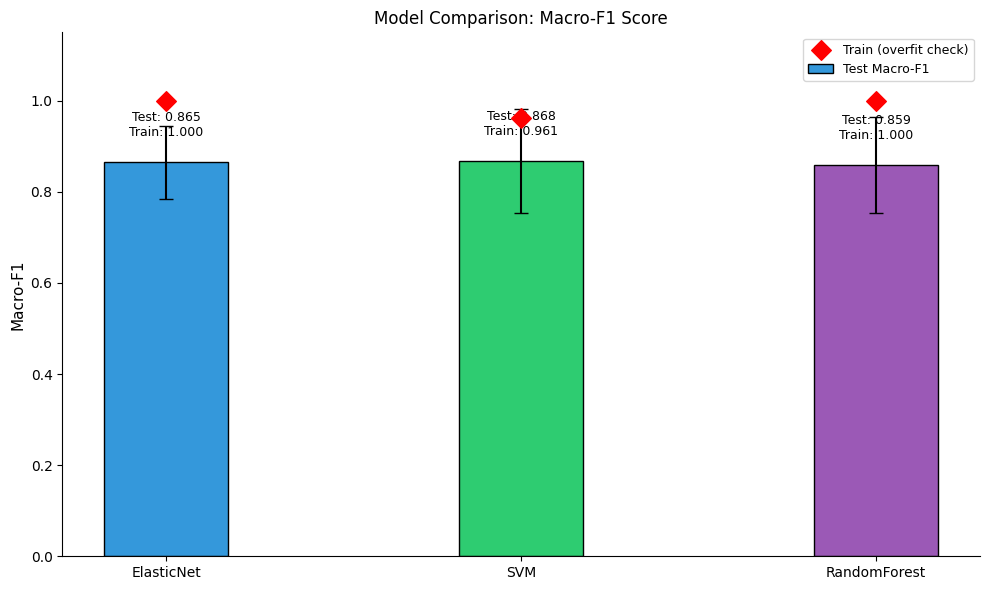

In [8]:
# Bar chart comparison
models = list(all_results.keys())
test_f1 = [all_results[m]["f1_macro"]["test_mean"] for m in models]
test_std = [all_results[m]["f1_macro"]["test_std"] for m in models]
train_f1 = [all_results[m]["f1_macro"]["train_mean"] for m in models]

x = np.arange(len(models))
width = 0.35
colors = ["#3498db", "#2ecc71", "#9b59b6"]

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(x, test_f1, width, label="Test Macro-F1", color=colors, edgecolor="black",
              yerr=test_std, capsize=5)
ax.scatter(x, train_f1, marker="D", s=100, color="red", label="Train (overfit check)", zorder=5)

for bar, tv, trv in zip(bars, test_f1, train_f1):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
            f"Test: {tv:.3f}\nTrain: {trv:.3f}", ha="center", va="bottom", fontsize=9)

ax.set_ylabel("Macro-F1")
ax.set_title("Model Comparison: Macro-F1 Score")
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
ax.set_ylim(0, 1.15)
fig.tight_layout()
fig.savefig(FIGURES_DIR / "03_model_comparison_f1.png", dpi=150, bbox_inches="tight")
plt.show()

## 4. Confusion Matrices

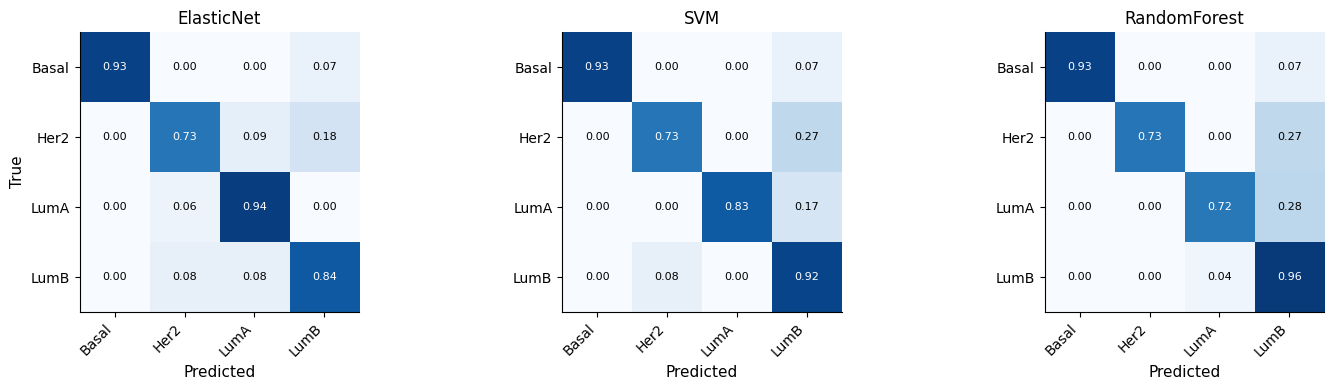

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, (name, pred) in enumerate(all_preds.items()):
    cm = confusion_matrix(y.values, pred, labels=CLASSES_USED)
    cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
    ax = axes[idx]
    im = ax.imshow(cm_norm, cmap="Blues", vmin=0, vmax=1)
    ax.set_xticks(np.arange(len(CLASSES_USED)))
    ax.set_yticks(np.arange(len(CLASSES_USED)))
    ax.set_xticklabels(CLASSES_USED, rotation=45, ha="right")
    ax.set_yticklabels(CLASSES_USED)
    ax.set_title(name)
    ax.set_xlabel("Predicted")
    if idx == 0:
        ax.set_ylabel("True")
    for i in range(len(CLASSES_USED)):
        for j in range(len(CLASSES_USED)):
            v = cm_norm[i, j]
            ax.text(j, i, f"{v:.2f}", ha="center", va="center",
                    color="white" if v > 0.5 else "black", fontsize=8)

plt.tight_layout()
plt.savefig(FIGURES_DIR / "03_all_confusion_matrices.png", dpi=150, bbox_inches="tight")
plt.show()

## 5. Per-Class F1 Comparison

Per-Class F1:


Model,ElasticNet,RandomForest,SVM
Subtype,,,
Basal,0.966,0.966,0.966
Her2,0.727,0.842,0.762
LumA,0.895,0.812,0.909
LumB,0.857,0.828,0.836


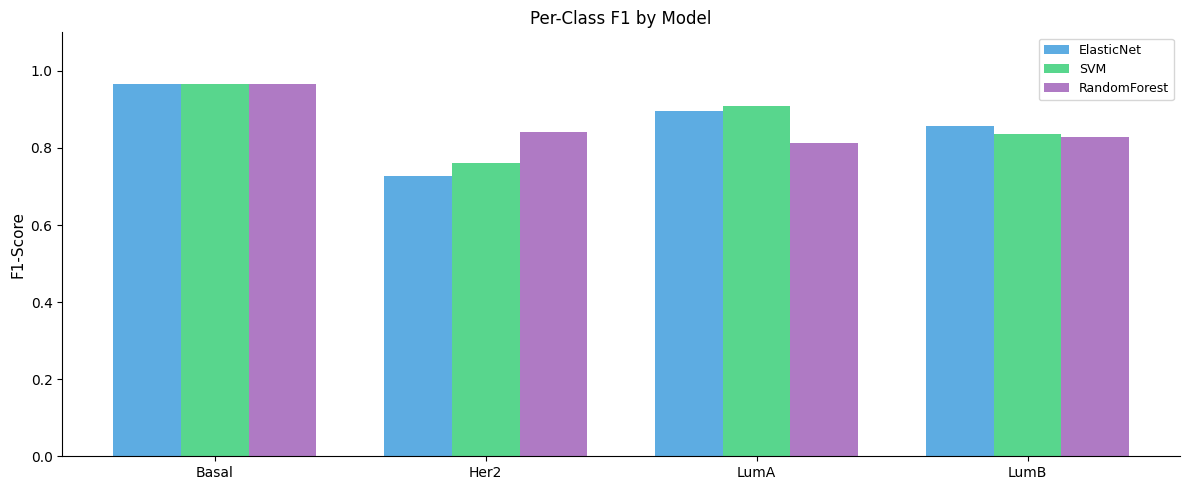

In [10]:
per_class = []
for name, pred in all_preds.items():
    rpt = classification_report(y.values, pred, target_names=CLASSES_USED, output_dict=True)
    for st in CLASSES_USED:
        per_class.append({"Model": name, "Subtype": st, "F1": rpt[st]["f1-score"]})

pc_df = pd.DataFrame(per_class)
pivot = pc_df.pivot(index="Subtype", columns="Model", values="F1")
print("Per-Class F1:")
display(pivot.round(3))

fig, ax = plt.subplots(figsize=(12, 5))
x = np.arange(len(CLASSES_USED))
width = 0.25
for i, name in enumerate(models):
    f1s = [pivot.loc[st, name] for st in CLASSES_USED]
    ax.bar(x + (i-1)*width, f1s, width, label=name, color=colors[i], alpha=0.8)

ax.set_ylabel("F1-Score")
ax.set_title("Per-Class F1 by Model")
ax.set_xticks(x)
ax.set_xticklabels(CLASSES_USED)
ax.legend()
ax.set_ylim(0, 1.1)
fig.tight_layout()
fig.savefig(FIGURES_DIR / "03_per_class_comparison.png", dpi=150, bbox_inches="tight")
plt.show()

## 6. Final Recommendation

In [11]:
best_model = max(all_results, key=lambda m: all_results[m]["f1_macro"]["test_mean"])
best_f1 = all_results[best_model]["f1_macro"]["test_mean"]
en_f1 = all_results["ElasticNet"]["f1_macro"]["test_mean"]
gap = best_f1 - en_f1

print("\n" + "=" * 60)
print("FINAL RECOMMENDATION")
print("=" * 60)
print(f"\nBest model: {best_model} (Macro-F1: {best_f1:.4f})")
print(f"ElasticNet: Macro-F1: {en_f1:.4f}")
print(f"Gap: {gap:.4f}")

if gap < 0.02:
    print("\nRECOMMENDATION: Use ElasticNet (interpretable, near-best performance)")
elif gap < 0.05:
    print(f"\nRECOMMENDATION: Consider {best_model} for prediction, ElasticNet for interpretability")
else:
    print(f"\nRECOMMENDATION: {best_model} significantly outperforms")

serializable = {
    m: {metric: {k: float(v) for k, v in vals.items()} for metric, vals in sc.items()}
    for m, sc in all_results.items()
}
with open(TABLES_DIR / "03_all_model_results.json", "w", encoding="utf-8") as f:
    json.dump(serializable, f, indent=2)
print("\nSaved 03_all_model_results.json")


FINAL RECOMMENDATION

Best model: SVM (Macro-F1: 0.8680)
ElasticNet: Macro-F1: 0.8650
Gap: 0.0030

RECOMMENDATION: Use ElasticNet (interpretable, near-best performance)

Saved 03_all_model_results.json
